<a href="https://colab.research.google.com/github/IvanKatorgin/Time-series/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Временные ряды". Домашнее задание 4. Модели Модели авторегрессии условной гетероскедантичности. Каторгин И.П.

Описание задания:
1. Выберите ряд из первого задания.
2. Постройте его модель GARCH.
3. Оформите отчёт в Jupyter-ноутбук.

In [105]:
# загрузим библиотеки
import numpy as np, pandas as pd, seaborn as sns, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from scipy.stats import boxcox
from scipy.optimize import minimize
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa import ar_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 21.2 MB/s eta 0:00:00


In [106]:
from arch import arch_model

In [107]:
# загрузим данные
female_births = pd.read_csv('daily-total-female-births-in-cal.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
airlines_passengers = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', sep = ',', header = 0, encoding = 'utf-8')['Deg']
robberies_in_boston = pd.read_csv('monthly-boston-armed-robberies-j.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
dowjones_closing = pd.read_csv('weekly-closings-of-the-dowjones-.csv', sep = ',', header = 0, encoding = 'utf-8')['Close']

In [108]:
all_series = {
    "Monthly sales of company X": sales_of_company_x,
    "Monthly Boston armed robberies": robberies_in_boston,
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp,
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing,
    "Daily total female births in California": female_births
}

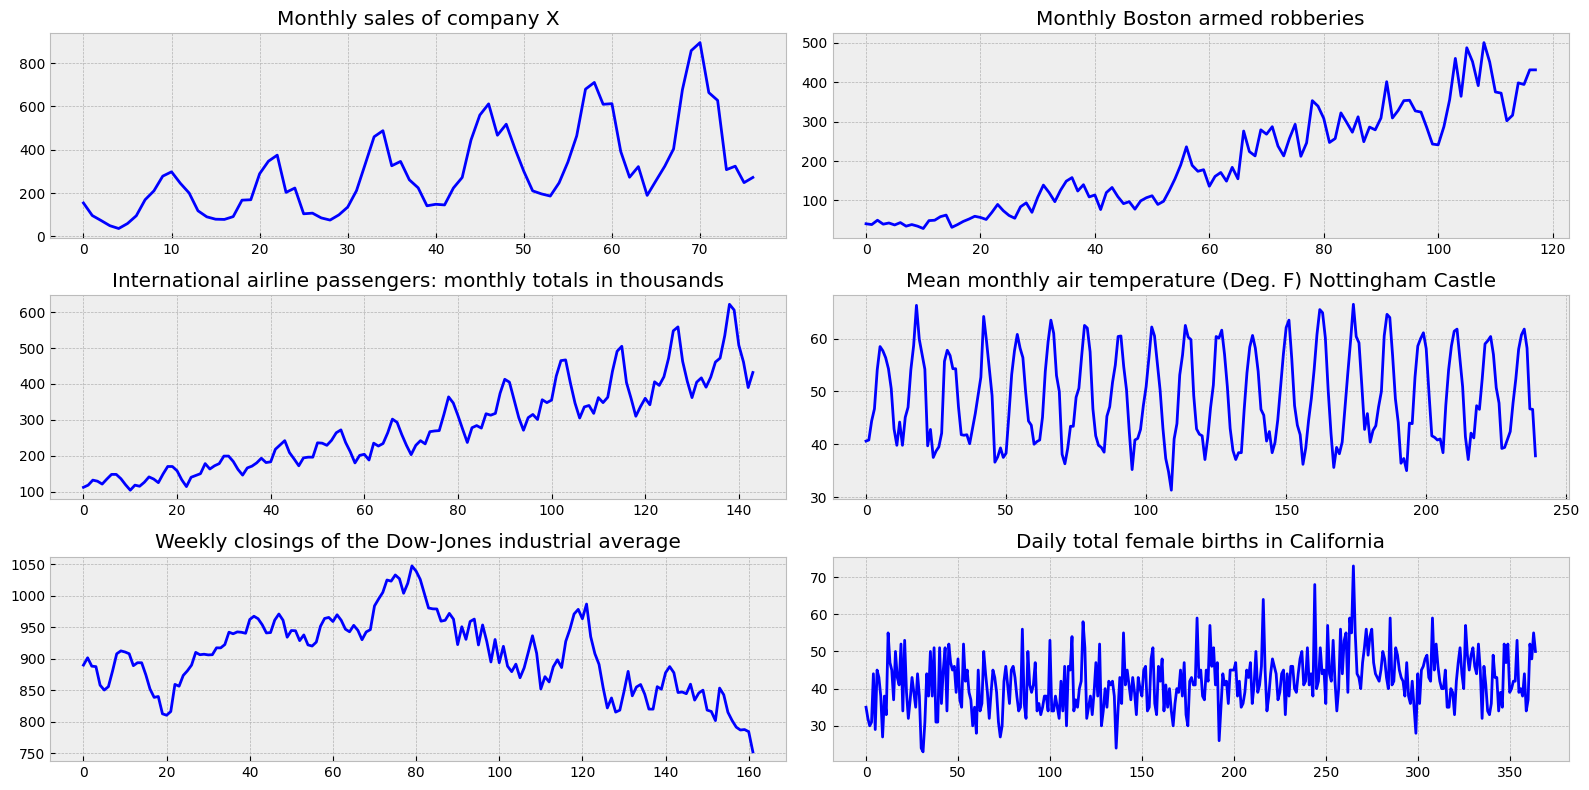

In [109]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [110]:
# Проверка стационарности временного ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [111]:
# Визуализация временного ряда
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

Возьмем временной ряд airlines_passengers, т.к. там есть и сезонность и тренд

In [112]:
series = airlines_passengers

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


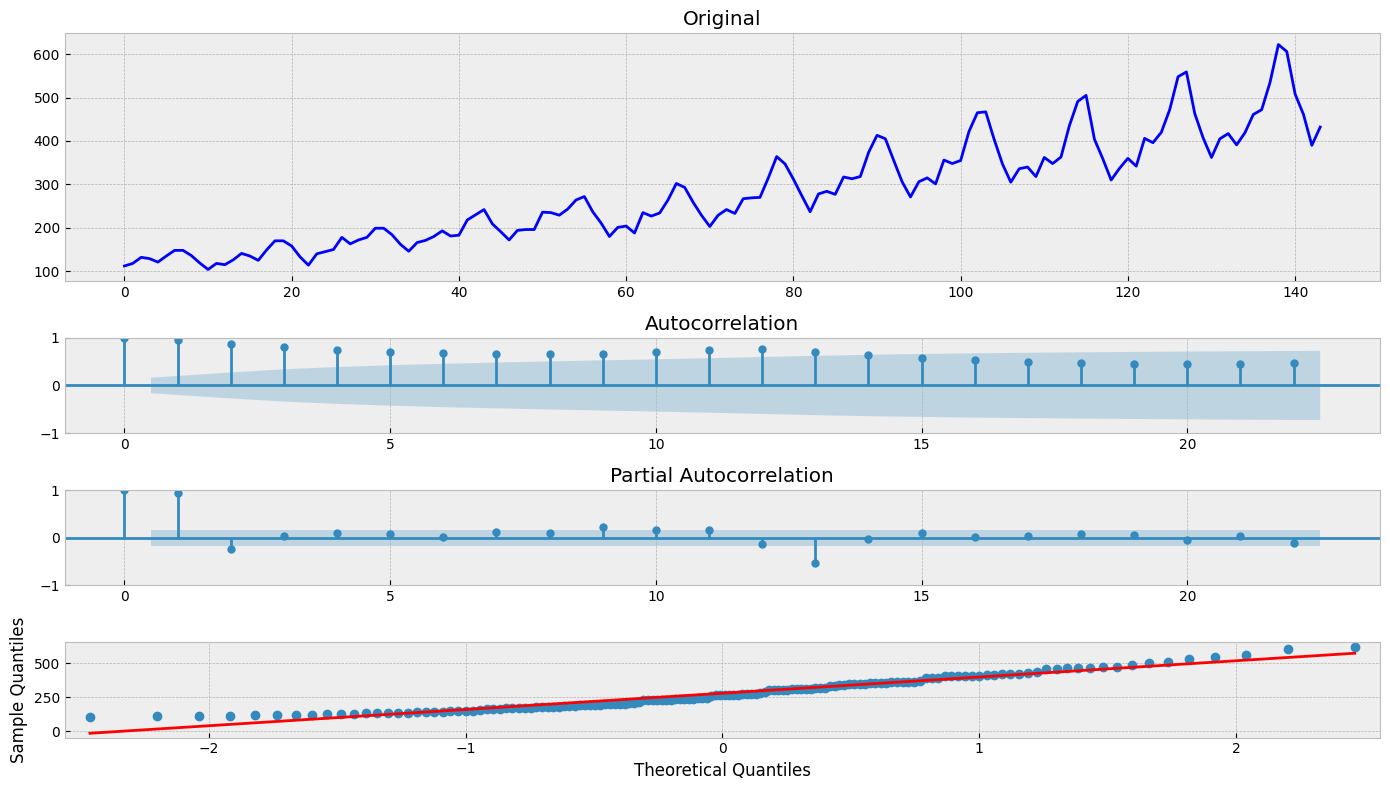

In [113]:
tsplot(series)

Уберем сезонность, тренд, разброс дисперсии

In [114]:
# функция автокорреляции
def fun_series (y, indx=1):

  total = pd.DataFrame( columns=['Lag','R'])

  for i in range(1, indx + 1):

    ser_a = pd.Series( y[:-i], name='A').reset_index(drop=True)
    ser_b =  pd.Series( y[i:], name='B').reset_index(drop=True)

    df = pd.concat([ser_a, ser_b], axis=1)

    total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
  return total.sort_values(by='R', ascending=False).reset_index(drop=True)

In [115]:
#  определим сезонность

sezon = fun_series (series, indx=24)['Lag'][0]

print('сезонность: ', sezon)

fun_series (series, indx=24).style.background_gradient(cmap='YlOrRd',axis=0)

сезонность:  12


<ipython-input-114-86a7af7c2537>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
<ipython-input-114-86a7af7c2537>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])


,Lag,R
0,12,0.990527
1,24,0.983254
2,1,0.960195
3,11,0.949702
4,13,0.948107
5,23,0.936717
6,2,0.895675
7,10,0.882713
8,14,0.875448
9,22,0.859013


In [116]:
# уберем изменение дисперсии при помощи преобразования Бокса-Кокса
series = boxcox(series, 0)

#  уберем наличие тренда (дифференцирование)

series = series[1:] - series[:-1]

# Уберем влияние сезонности
series = series[sezon:] - series[:-sezon]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


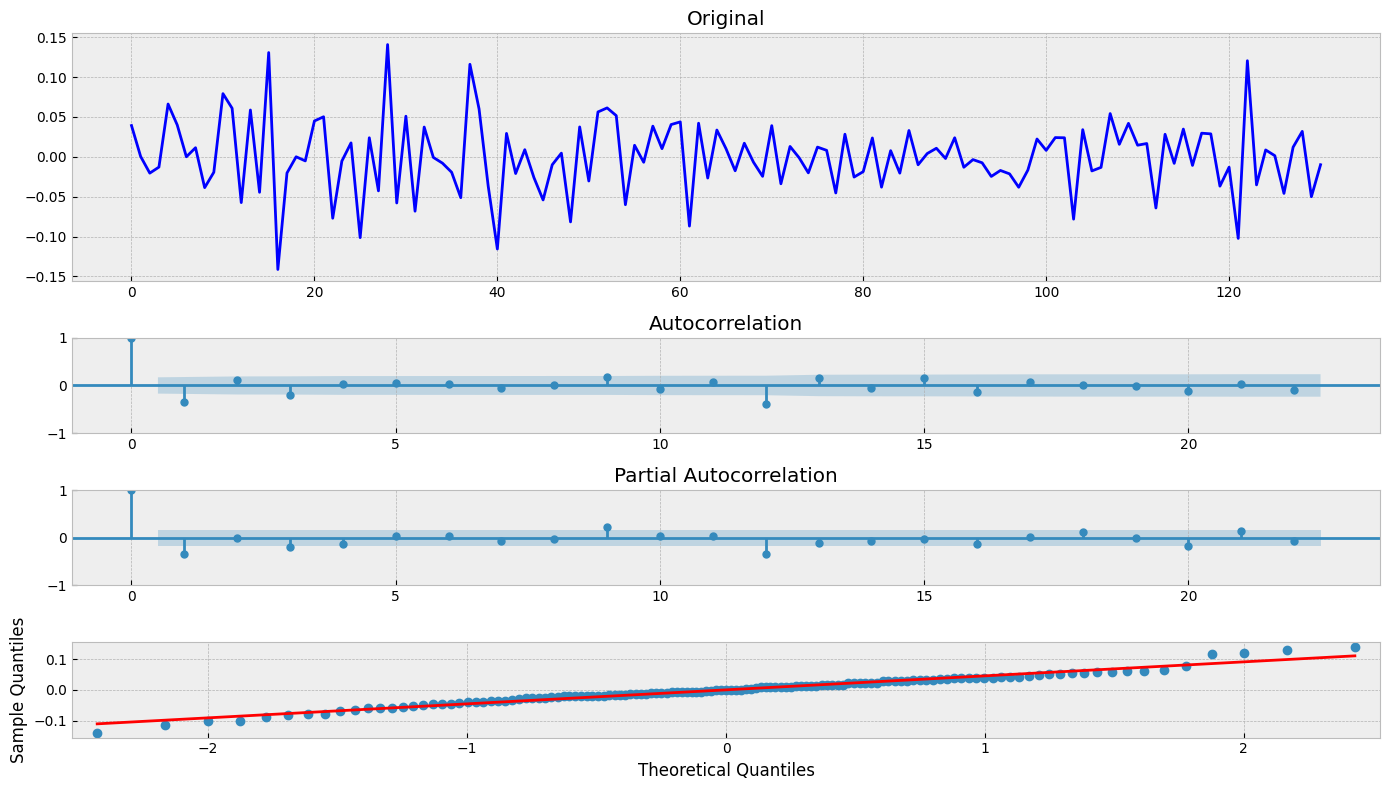

In [117]:
tsplot(series)

Теперь ряд стационарный можно строить модели

Построим модель ARIMA

In [118]:
series_1 = series.astype(float)

In [119]:
# Функция для поиска лучшей модели ARIMA
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = ARIMA(TS, order=(i, d, j), trend='n').fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [120]:
# Поиск лучшей модели ARIMA
aic, order, mdl = _get_best_model(series_1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

Best model: aic: -458.15891 | order: (3, 0, 3)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
order

(3, 0, 3)

In [122]:
# Функция для построения графиков остатков модели
def tsplot1(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, (pd.Series, np.ndarray)):
        y = np.array(y)

    plt.style.use(style)
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title('Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    qq_ax = fig.add_subplot(111)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.hist(y, bins=30, edgecolor='k')
    plt.title('Histogram of residuals')
    plt.show()

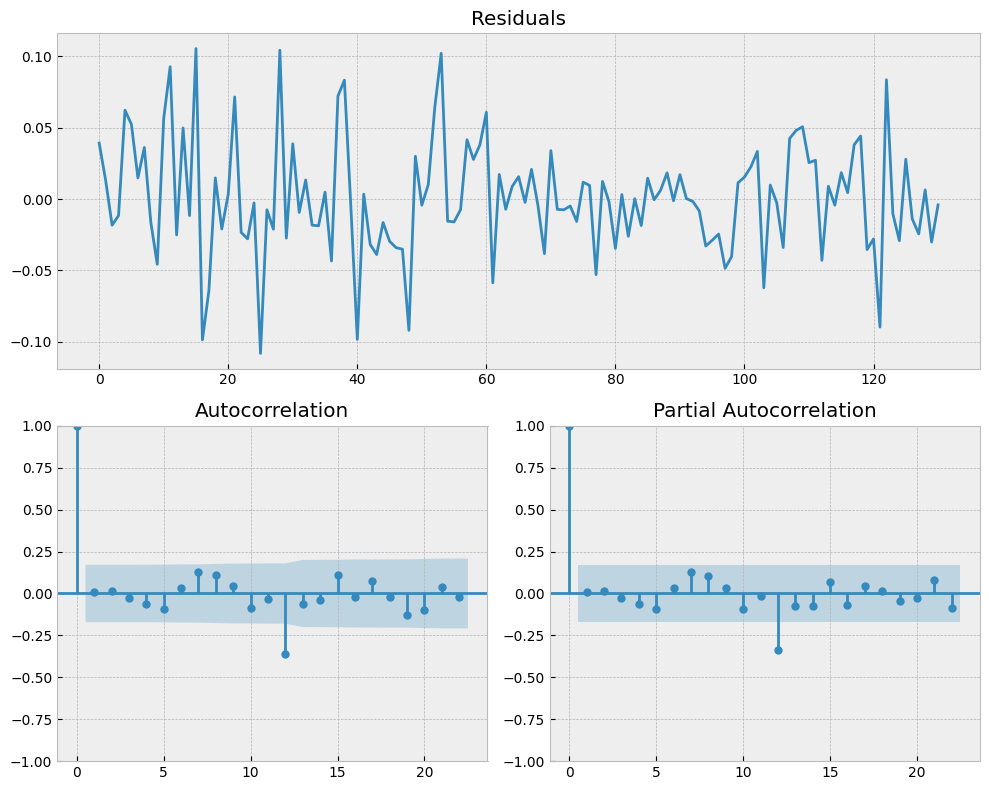

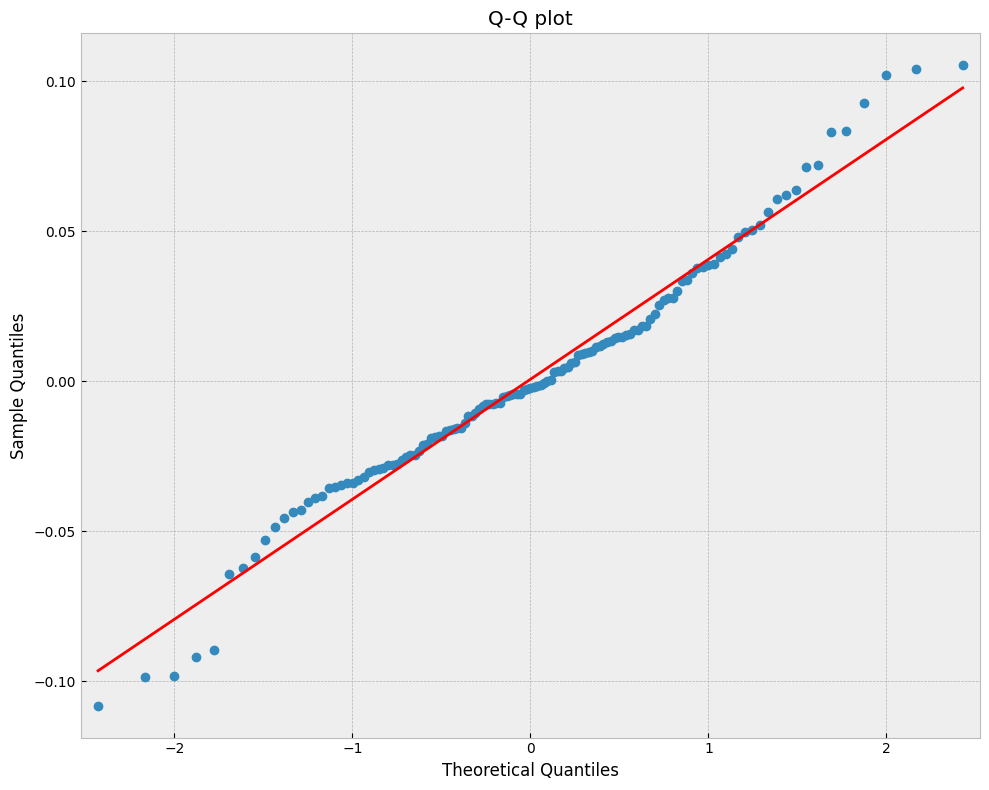

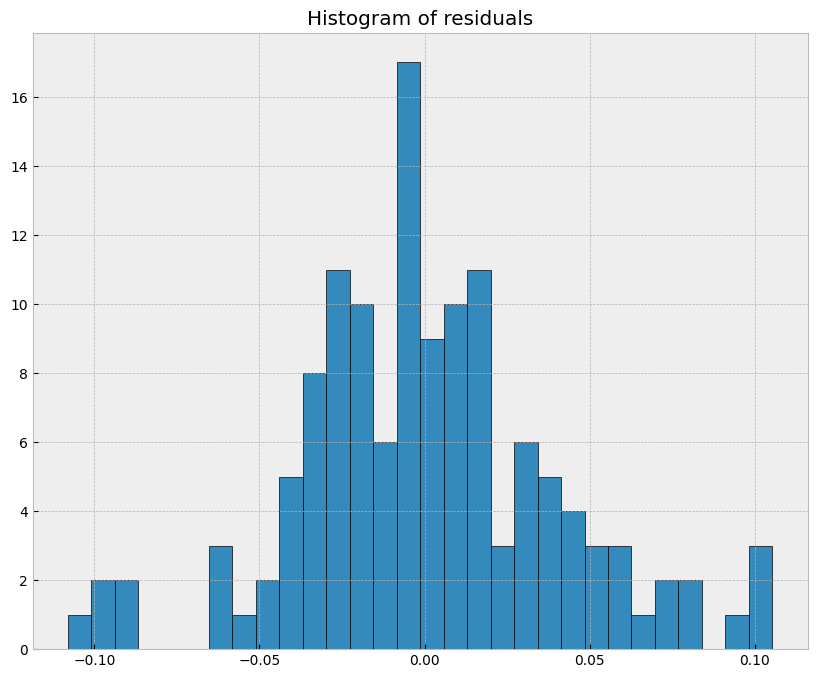

In [123]:
# Визуализация остатков модели
tsplot1(mdl.resid)

In [128]:
# сделаем предсказания
predict = mdl.predict(start=120, end=150)
predict

array([ 0.01483746, -0.01276092,  0.03699762, -0.02483616,  0.03770449,
       -0.02649774, -0.03204764,  0.03643983,  0.02543058, -0.01998166,
       -0.00588287,  0.00286203,  0.02600475,  0.0006871 , -0.02228255,
       -0.00753041,  0.01839273,  0.01219145, -0.01331733, -0.01504511,
        0.00785226,  0.01607239, -0.0025412 , -0.01547533, -0.00215585,
        0.01356611,  0.00590967, -0.01072714, -0.00852897,  0.00736445,
        0.00995608])

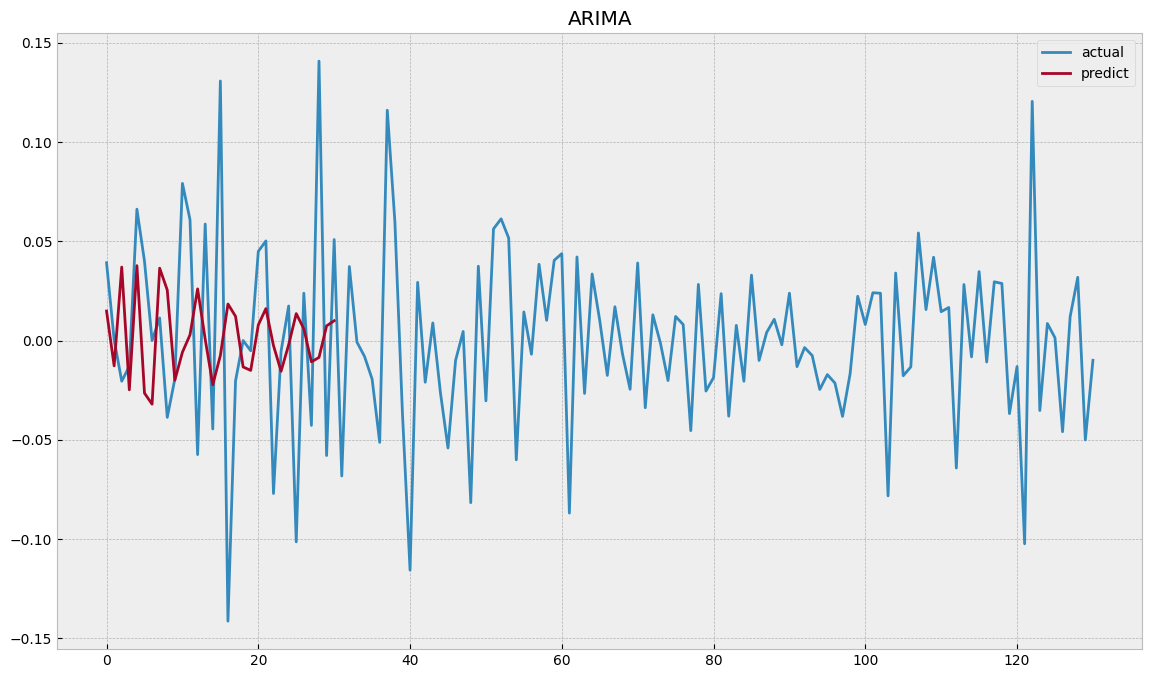

In [129]:
# построим график предсказаний
plt.figure(figsize=(14, 8))
plt.plot(series_1, label="actual")
plt.plot(predict, label="predict")
plt.legend(loc="best")
plt.title("ARIMA")
plt.grid(True)

Применим GARCH

In [130]:
order

(3, 0, 3)

In [131]:
# Применение модели GARCH к новой временной серии
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(series_1*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     54,   Neg. LLF: 538.9127928376812
Iteration:     10,   Func. Count:    109,   Neg. LLF: 373.7376496424363
Iteration:     15,   Func. Count:    159,   Neg. LLF: 373.68044662507486
Iteration:     20,   Func. Count:    209,   Neg. LLF: 373.66316419206044
Optimization terminated successfully    (Exit mode 0)
            Current function value: 373.66316230869927
            Iterations: 22
            Function evaluations: 228
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -373.663
Distribution:      Standardized Student's t   AIC:                           765.326
Method:                  Maximum Likelihood   BIC:                        

In [132]:
# Прогнозирование на основе модели GARCH
forecast = res.forecast(horizon=100)

In [133]:
series_1.shape

(131,)

In [134]:
series_1[-5:]

array([-0.04593429,  0.01202388,  0.03183046, -0.05008233, -0.00996401])

In [135]:
forecast

In [136]:
forecast.residual_variance.iloc[-1]

,130
h.001,22.286068
h.002,20.815369
h.003,15.998726
h.004,21.740219
h.005,21.062139
...,...
h.096,25.254768
h.097,25.282309
h.098,25.312331
h.099,25.341167


[22.28606776 20.81536908 15.99872643 21.74021916 21.06213941 17.12232364
 21.41971035 21.25493863 18.06742139 21.26458906 21.41772967 18.86493577
 21.22920179 21.56590311 19.54120258 21.27903495 21.70890189 20.11833938
 21.38819678 21.85211997 20.61470367 21.53742494 21.99826087 21.04538149
 21.71252102 22.14829749 21.42266571 21.90312872 22.30214026 21.75650049
 22.10178658 22.45909366 22.05488005 22.3031982  22.61816102 22.32419715
 22.5036737  22.77824185 22.56954171 22.70070503 22.93825398 22.79495256
 22.89264516 23.09720424 23.00362686 23.07846753 23.25422451 23.19809232
 23.25758695 23.40858516 23.38034747 23.42972729 23.55969449 23.5519748
 23.59482471 23.70708978 23.7142314  23.75295736 23.85042394 23.86812099
 23.9042951  23.98945047 24.01445073 24.04906383 24.12400815 24.15387585
 24.18752066 24.2540066  24.28693436 24.31993692 24.37941312 24.414074
 24.44658686 24.50024116 24.53567301 24.5677403  24.61654039 24.65205605
 24.68365823 24.72838826 24.76350634 24.79459023 24.83

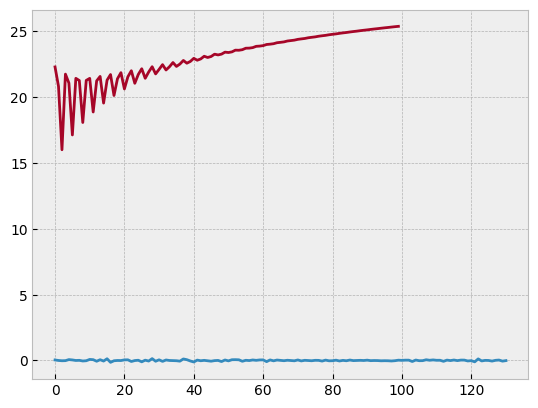

In [137]:
# Визуализация прогнозов и остатков
plt.plot(series_1)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*100 + forecast.residual_variance.iloc[-1].values)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


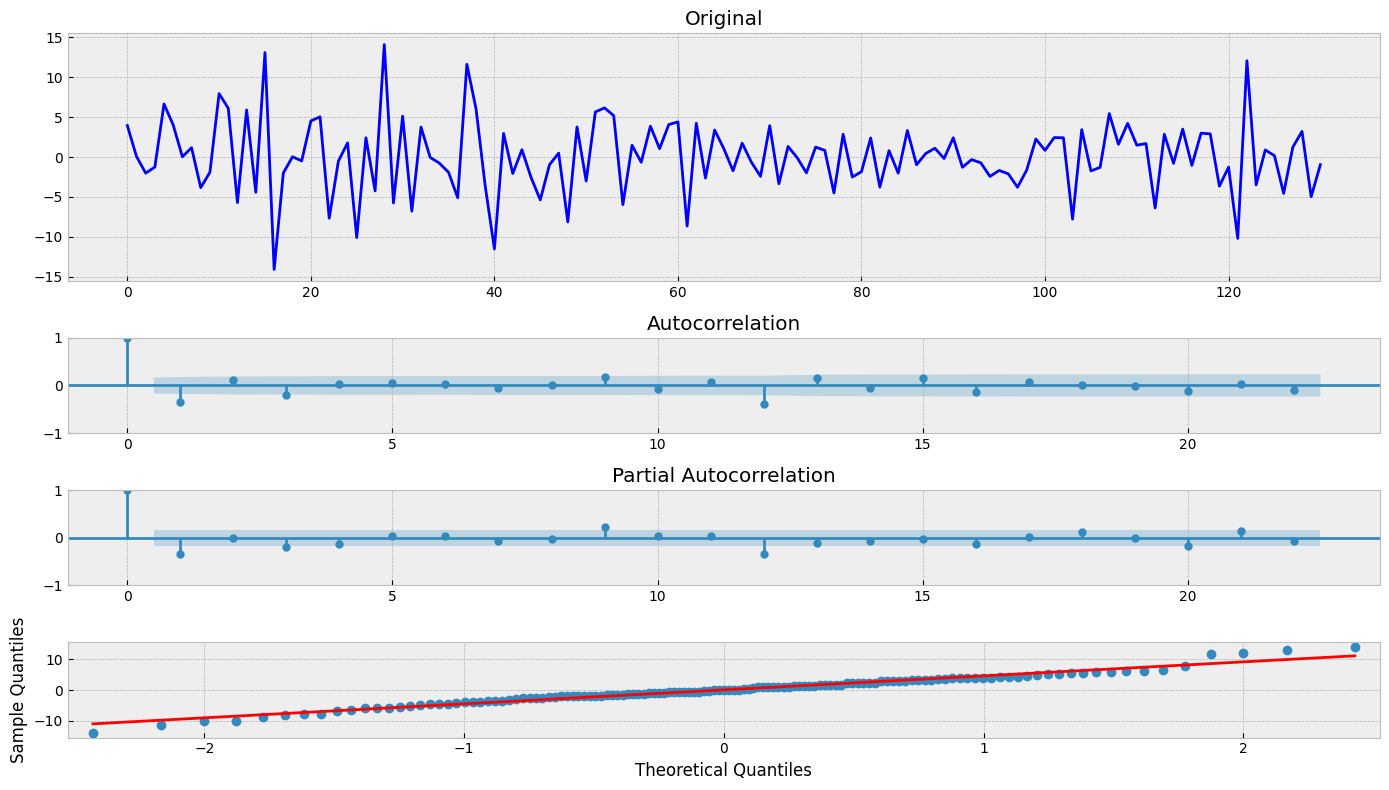

In [138]:
tsplot(res.resid)

Cпрогнозируем график классическим ML

In [148]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Date"], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [149]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, lag_start=1, lag_end=20, test_size=0.3)

In [150]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
2,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
3,133.0,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
4,114.0,133.0,158.0,170.0,170.0,149.0,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,465.0,422.0,355.0,348.0,356.0,301.0,315.0
97,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,465.0,422.0,355.0,348.0,356.0,301.0
98,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,465.0,422.0,355.0,348.0,356.0
99,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0,336.0,305.0,347.0,404.0,467.0,465.0,422.0,355.0,348.0


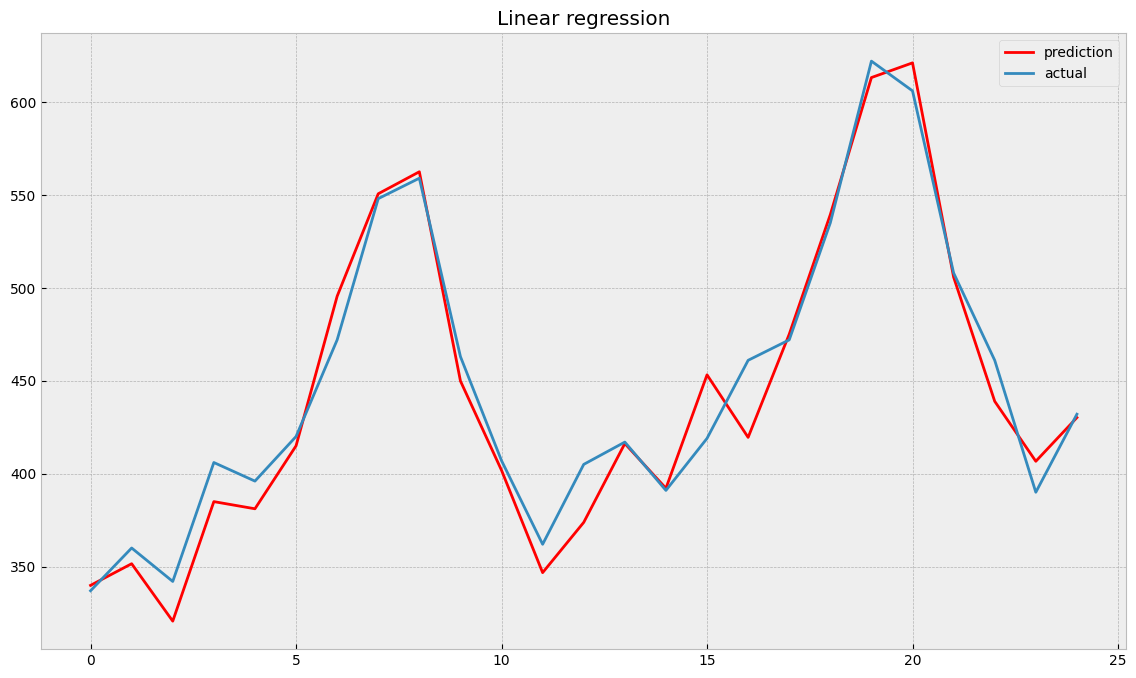

In [151]:
# Строим модель линеной регресии и график предсказания
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [152]:
# оценим качество модели
print(f"MAE: {mean_absolute_error(y_test, prediction)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
print(f"MSE: {mean_squared_error(y_test, prediction)}")
print(f"RMSE: {mean_squared_error(y_test, prediction, squared=False)}")
print(f"R2: {r2_score(y_test, prediction)}")
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Median absolute error: {median_absolute_error(y_test, prediction)}")

MAE: 12.791089057005161
MAPE: 0.02985381223601418
MSE: 287.96839470353626
RMSE: 16.96963154295155
R2: 0.9508893960507165
Explained variance score: 0.9539369933236268
Median absolute error: 8.835941743829721


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


В целом качество модели по выбранным параметрам довольно высокое и модель можно использовать для выбранного ряда

Выводы по работе:

В работе были построены модели ARIMA и GARCH, а так же модель линейной регрессии. Все модели получились приемлемого качетва и могут быть использованы в дальнейшем в рядах подобного типа
